### Import required libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.style.use('ggplot')
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
#from ipywidgets import interact, HBox, Label, VBox

### Set input values here

In [2]:
style = {'description_width': 'initial'}   

W = widgets.FloatText(description='Distributed recharge (m/d):',disabled=False,style=style)
width = widgets.FloatText(description='Width of pit (m):',disabled=False,style=style)
length = widgets.FloatText(description='Length of pit (m):',disabled=False,style=style)
kh1= widgets.FloatText( description='Kh - zone 1 (m/d):',disabled=False,style=style)   
kh2 = widgets.FloatText(description='Kh - zone 2 (m/d):',disabled=False,style=style)
#kv = widgets.FloatText(description='Kv - zone 2 (m/d):',disabled=False,style=style)
pitbase = widgets.FloatText(description='Pitbase elevation (mAHD):',disabled=False,style=style)
sGWL = widgets.FloatText(description='Static groundwater elevation (mAHD):',disabled=False,style=style)

#display FloatText widgets
display(W)
display(width) 
display(length) 
display(kh1) 
display(kh2) 
#display(kv) 
display(pitbase) 
display(sGWL) 

def on_value_change(change):
    return(change)
 
W.observe(on_value_change, names='value')
width.observe(on_value_change, names='value')
length.observe(on_value_change, names='value')
kh1.observe(on_value_change, names='value')
kh2.observe(on_value_change, names='value')
pitbase.observe(on_value_change, names='value')
sGWL.observe(on_value_change, names='value')

FloatText(value=0.0, description='Distributed recharge (m/d):', style=DescriptionStyle(description_width='init…

FloatText(value=0.0, description='Width of pit (m):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Length of pit (m):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Kh - zone 1 (m/d):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Kh - zone 2 (m/d):', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Pitbase elevation (mAHD):', style=DescriptionStyle(description_width='initia…

FloatText(value=0.0, description='Static groundwater elevation (mAHD):', style=DescriptionStyle(description_wi…

### Pit inflow model

effective radius is:  282.09 m
Anistrophy is  3.16
      R0_m  zone_1_pit_inflow_m3/d  drawdown_m  zone_2_pit_inflow_m3/d  \
50    0.00                    0.00       150.0                    0.00   
49    0.00                    0.00       151.0                    0.00   
48  376.35                  389.94       152.0                    7.14   
47  395.93                  484.97       153.0                   10.70   
46  411.96                  566.33       154.0                   14.27   
45  425.70                  638.65       155.0                   17.84   
44  437.81                  704.34       156.0                   21.41   
43  448.67                  764.82       157.0                   24.98   
42  458.53                  821.05       158.0                   28.55   
41  467.57                  873.66       159.0                   32.11   

    total_pit_inflow_m3/d  pit_level_mRL  
50                   0.00          250.0  
49                   0.00          249.0  
48   

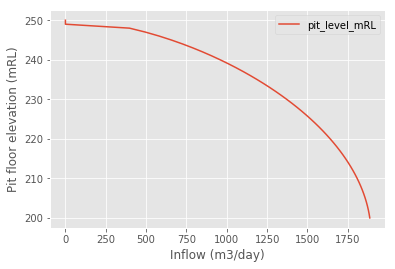

In [3]:
effectcircradius = math.sqrt(width.value*length.value/math.pi)
print ('effective radius is: ',round(effectcircradius,2), 'm')

#input parameters for pit inflow 
hp = 0
ani = math.sqrt(kh2.value/(kh2.value/10))
h0 = sGWL.value - pitbase.value
print ('Anistrophy is ',round(ani,2))

#create a dictionary of lists with headers roi and pitinflow
results = {'R0_m':[],'zone_1_pit_inflow_m3/d':[],'drawdown_m':[],'zone_2_pit_inflow_m3/d':[],
               'total_pit_inflow_m3/d':[],'pit_level_mRL':[]}

#iterate through r0 values to find r0 equaling h0 from input
while hp <= h0:
    r0_lower = 0.0001
    r0_upper = 100000
    erra = 100
    margin = 0.0000001
    iter = 0
    while erra > margin and iter < 1000:
        r0_mid = ((r0_upper + r0_lower) / 2)
        h0calc_m = math.sqrt(hp ** 2 + ((W.value / kh1.value) * (((r0_mid ** 2) * math.log(r0_mid / effectcircradius)) - 
                          ((r0_mid ** 2 - effectcircradius ** 2) / 2))))    
        closeenough = math.isclose(h0,h0calc_m,rel_tol=0.000001,abs_tol=margin)
        if h0 >= h0calc_m:
            r0_lower = r0_mid
        else:
            r0_upper = r0_mid  

        iter = iter +1  

        '''print(r0_upper)
        print('r0 is ',r0_mid)
        print(r0_lower)
        print('h0calc is ', h0calc_m)'''

        if r0_mid <= 0.001:
            radiusofinfluence = r0_mid
            zone_1_pit_inflow = 0.0
            zone_2_pit_inflow = 0.0
        else:                
            radiusofinfluence = r0_mid
            zone_1_pit_inflow = W.value*math.pi*(radiusofinfluence**2-effectcircradius**2)
            zone_2_pit_inflow = 4*(kh2.value/ani)*effectcircradius*(h0-hp)

        total_pit_inflow = zone_1_pit_inflow + zone_2_pit_inflow
        lake_level = pitbase.value + hp

        if closeenough is True:
            break

    # append data into list in dictionary
    results['R0_m'].append(round(radiusofinfluence,2))
    results['zone_1_pit_inflow_m3/d'].append(round(zone_1_pit_inflow,2))
    results['drawdown_m'].append(round(pitbase.value-hp,2))
    results['zone_2_pit_inflow_m3/d'].append(round(zone_2_pit_inflow,2))
    results['total_pit_inflow_m3/d'].append(round(total_pit_inflow,2))
    results['pit_level_mRL'].append(round(lake_level,2))

    if hp <= h0:
        hp=hp+1

    else:
        break

#name output file
K = str(kh1.value)
distrutedRecharge =str(W.value)
dt = str(datetime.now())
dt1 = dt.split('.')
dt2=dt1[0].replace(':','-')
output = 'K_'+ K + 'Recharge_' + distrutedRecharge+ '_pit_inflow_output_'+ dt2+'.csv'

#put dictionary into dataframe and then export dataframe to .csv file
df1=pd.DataFrame.from_dict(results,'columns')
df1.sort_values(by='R0_m',ascending=True,inplace=True)

#save t csv file
#df1.to_csv(output,sep=',',columns=['R0_m','zone_1_pit_inflow_m3/d','zone_2_pit_inflow_m3/d',
                                       #  'drawdown_m','pit_level_mRL','total_pit_inflow_m3/d'],header=True,index=False)
print(df1.head(10))
print ('Success - Pit inflow calculated. Results exported to',output)

#results
#print(df1)
#chart
#fig, ax = plt.subplots()
ax = df1.plot(x='total_pit_inflow_m3/d', y='pit_level_mRL',)
ax.set_xlabel('Inflow (m3/day)')
ax.set_ylabel('Pit floor elevation (mRL)')

plt.show()

In [4]:
print(W.observe.__doc__)

Setup a handler to be called when a trait changes.

        This is used to setup dynamic notifications of trait changes.

        Parameters
        ----------
        handler : callable
            A callable that is called when a trait changes. Its
            signature should be ``handler(change)``, where ``change`` is a
            dictionary. The change dictionary at least holds a 'type' key.
            * ``type``: the type of notification.
            Other keys may be passed depending on the value of 'type'. In the
            case where type is 'change', we also have the following keys:
            * ``owner`` : the HasTraits instance
            * ``old`` : the old value of the modified trait attribute
            * ``new`` : the new value of the modified trait attribute
            * ``name`` : the name of the modified trait attribute.
        names : list, str, All
            If names is All, the handler will apply to all traits.  If a list
            of str, handler wil

In [5]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        (change['new'])

int_range.observe(on_value_change, names='value')

IntSlider(value=0)

Output()